In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from PIL import ImageFilter
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision.models import vgg16
from torchvision import transforms

In [2]:
# model = vgg16(pretrained=True)
class Vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.modules_no = [1,3,6,8,11,13,15,18,20,22,25,27,29]
#         [0,2,5,7,10,12,14,17,19,21,24,26,28]
        self.features = vgg16(pretrained=True).features  
        self.avgpool = vgg16(pretrained=True).avgpool
        self.classifier = vgg16(pretrained=True).classifier
        
    def forward(self,x):
        results = {}
        for index,layer in enumerate(self.features):
            x = layer(x)
            if index in self.modules_no:
                results[index] = x 
        
        x = self.avgpool(x)
        results[31] = x
        
        x = x.view(-1,512*7*7)
        
        for index,layer in enumerate(self.classifier):
            x = layer(x)
            if index == 6:
                results[38] = x
                
        return results

In [3]:
model = Vgg16()
for param in model.parameters():
    param.requires_grad = False
    
model = model.cuda()

In [4]:
mean=torch.tensor([0.485, 0.456, 0.406]).unsqueeze(0).unsqueeze(2).unsqueeze(3).cuda()
std=torch.tensor([0.229, 0.224, 0.225]).unsqueeze(0).unsqueeze(2).unsqueeze(3).cuda()

In [5]:
def norm_clip(x,percentile):
    y=x.reshape(3,img_size*img_size).permute(1,0).cpu()
    y[y.norm(dim=1)<np.percentile(y.norm(dim=1),percentile)]=0
    return y.permute(1,0).reshape(1,3,img_size,img_size).cuda()

In [6]:
def clip_small_contri(x,percentile,img_size):
    y = (x*x.grad).sum(1).abs().cpu()
    x[(y<np.percentile(y,percentile)).expand(3,img_size,img_size).unsqueeze(0)]=0
    return x.cuda()
    

Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  0  	Loss :  0.8022228479385376
56 x 56
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  40  	Loss :  48.247188568115234
56 x 56


C:\Users\Lenovo\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  80  	Loss :  72.90640258789062
67 x 67
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  120  	Loss :  192.1577911376953
80 x 80
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  160  	Loss :  202.126953125
96 x 96
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  200  	Loss :  298.03399658203125
115 x 115
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  240  	Loss :  325.3912658691406
138 x 138
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  280  	Loss :  302.6695556640625
165 x 165
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  320  	Loss :  310.52008056640625
198 x 198
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  360  	Loss :  377.77301025390625
237 x 237
Learning rate :  0.01 	Layer :  38 	Channel :  251 	iteration :  399  	Loss :  419.599365234375
284 x 284


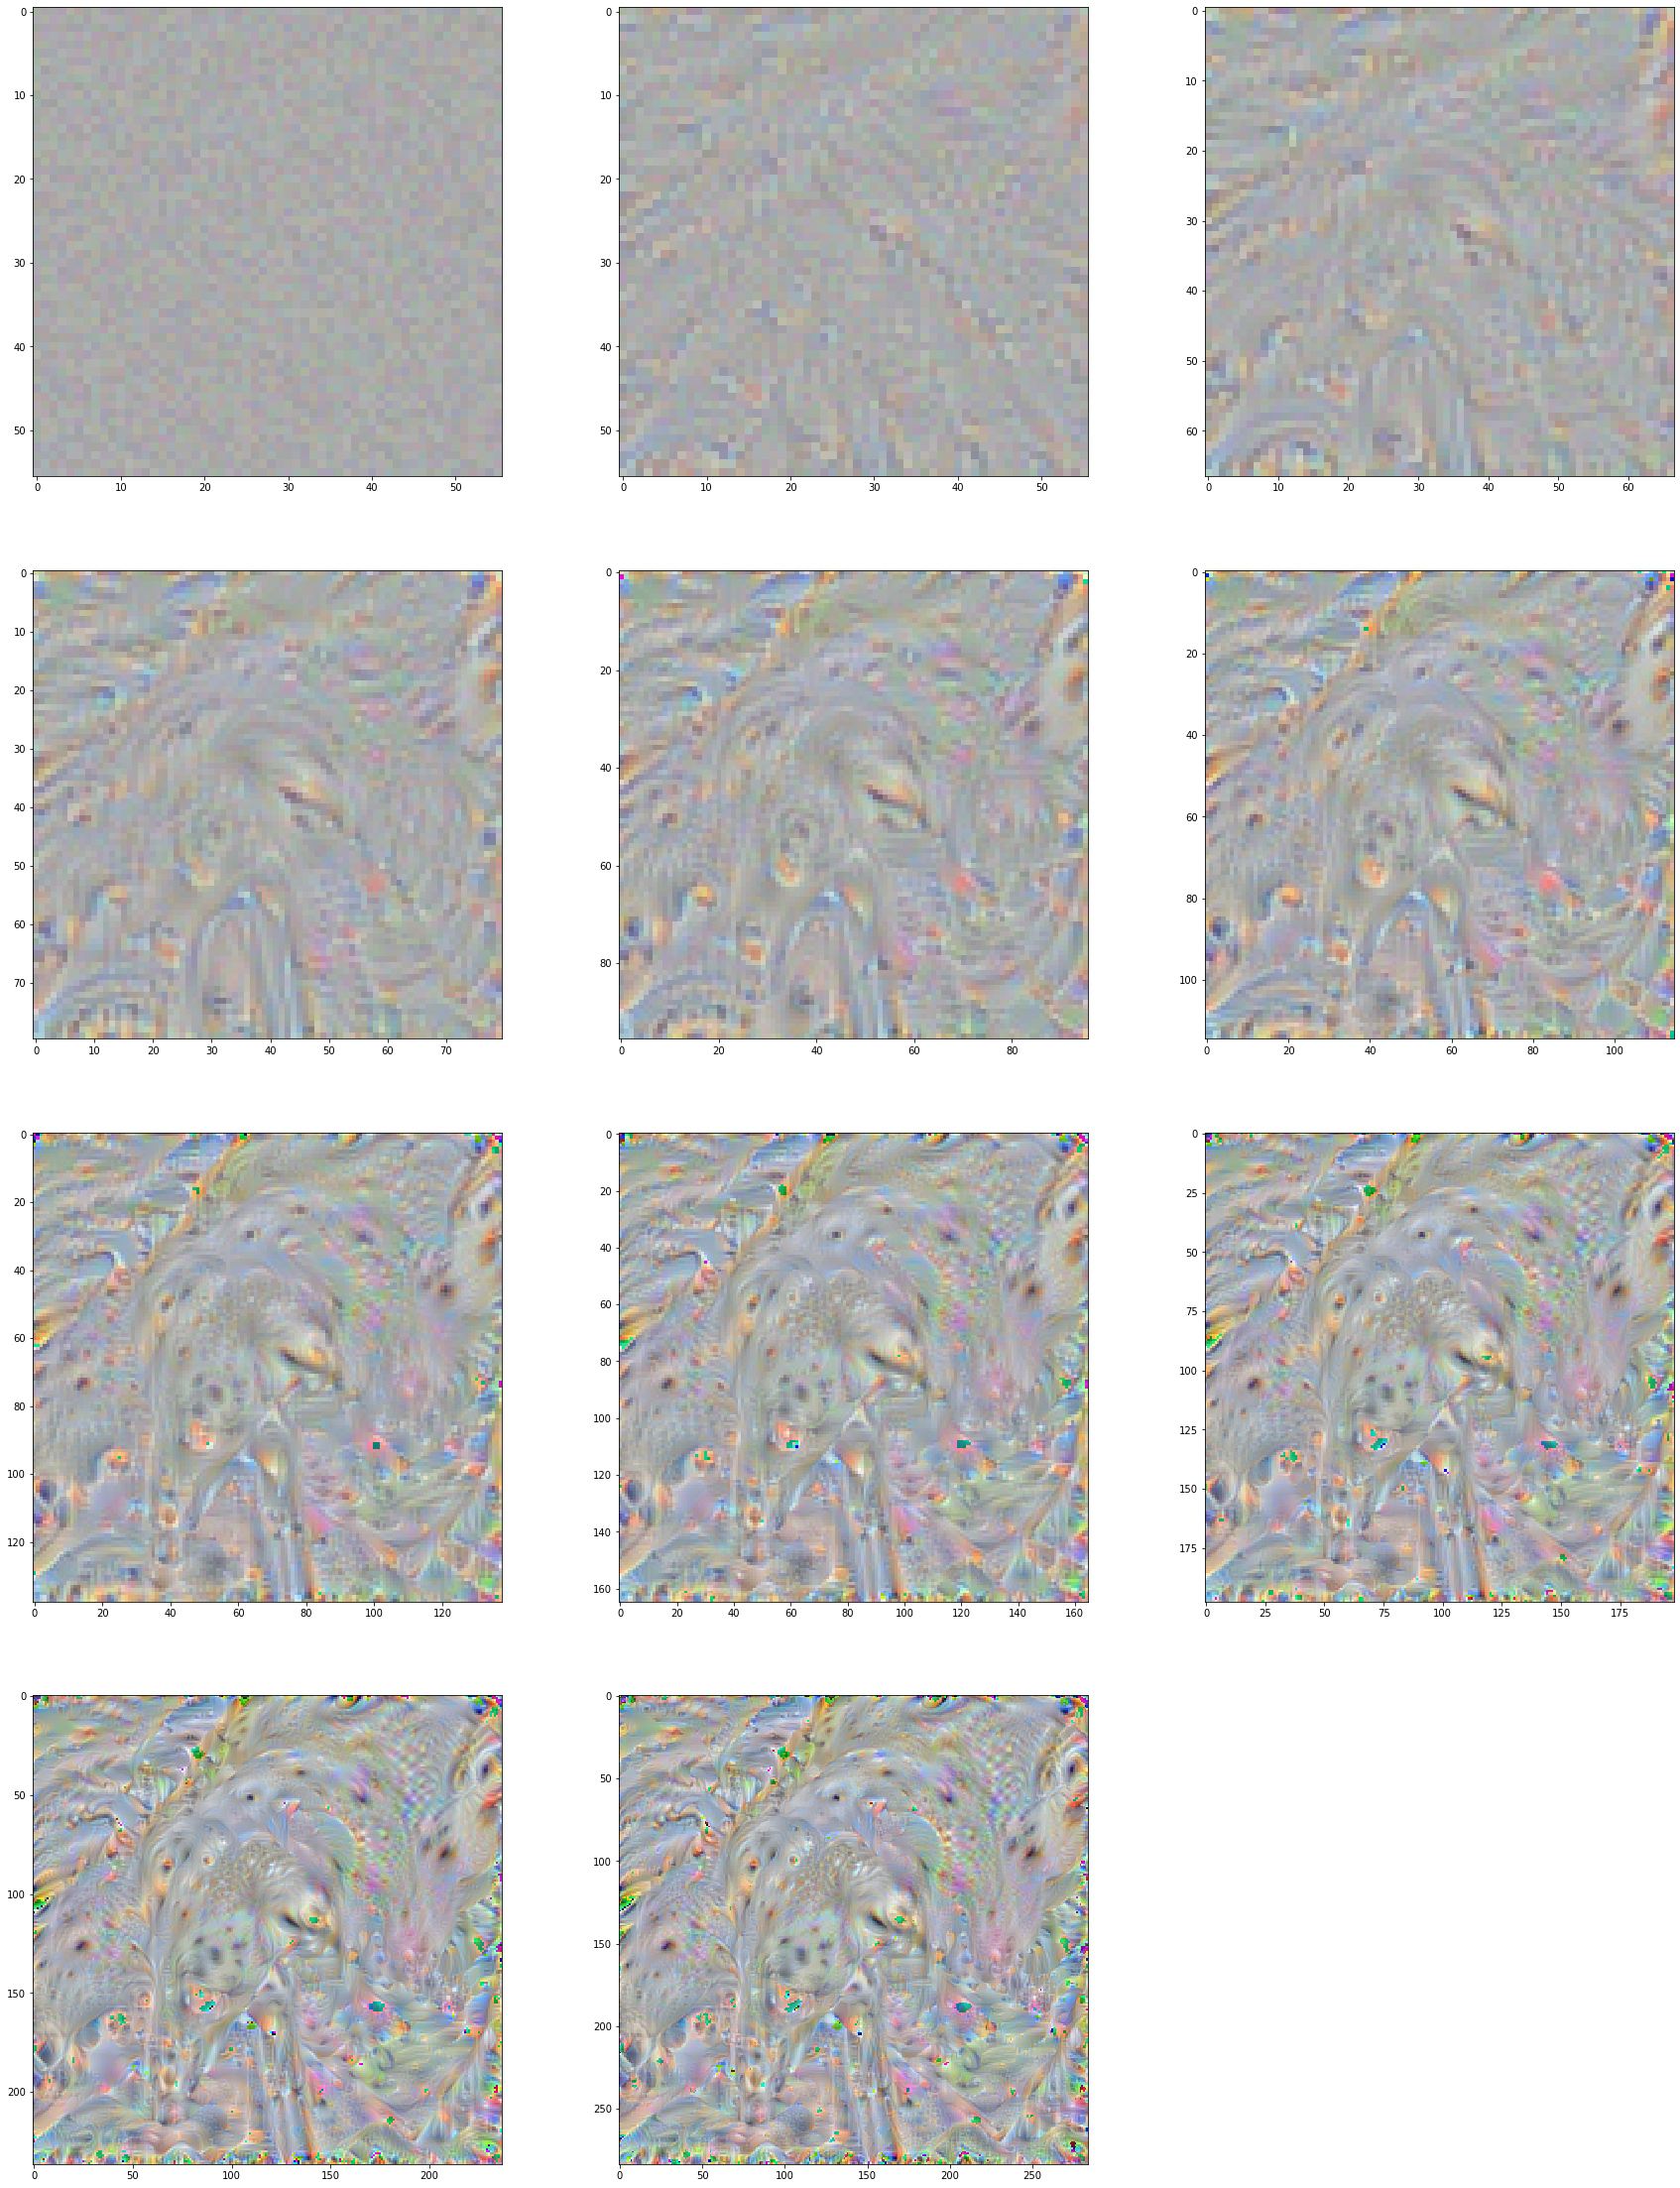

In [7]:
layers = [38]
learning_rate = [.01]
n_channels = 1
iterations = 400
afterEvery = 40
start = afterEvery
upto = iterations
img_size = 56
random_low = 160
random_high = 180
upscaleFactor = 1.2
upscale = nn.Upsample(scale_factor=upscaleFactor,mode='bicubic')


for rate in learning_rate:
    for layer in layers:
        for ch_i in range(n_channels):
            image = (((random_high - random_low)*torch.rand(1,3,img_size,img_size) + random_low)/255).cuda()
            img = (image - mean)/std
            img.requires_grad = True
            optimizer = optim.Adam([img],lr=rate,weight_decay=.0001)
#             Loss_arr =[]
            out = model(img)
            channel = torch.randint(out[layer].size()[1],(1,))
#             channel = torch.tensor(130)
            plt.figure(figsize=(30,40))

        
            for i in range(iterations):
                if(i!=0) :
                    out = model(img)
                kernel = out[layer][0][channel]

                loss = -kernel.mean()

#                 Loss_arr.append(-loss.item())
                
#                FINDING NON-ZERO LOSS IF INITIAL RANDOMLY CHOSEN KERNEL HAS ZERO LOSS
                if loss == 0 and i==0:
                    print('Finding non-zero loss kernel')
                    while loss == 0:
                        channel = torch.randint(out[layer].size()[1],(1,))
                        kernel = out[layer][0][channel]
                        loss = -kernel.mean()
                        print('Tried channel index - ',channel.item(),' Loss - ',loss.item())

                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
#                 CLIPPING PIXELS WITH SMALL NORM AND SMALL CONTRIBUTIONS
                if i%1 == 0 & i != 0:
                    img.detach_()
                    img = norm_clip(img,100)
                    img = clip_small_contri(img,100,img_size)
                    img.requires_grad_()
                
#                 APPLYING GAUSSIAN BLUR
                if i%2 == 0 & i != 0:
                    img=transforms.ToPILImage()(img.cpu()[0])
                    img=img.filter(ImageFilter.GaussianBlur(radius=5))
                    img=transforms.ToTensor()(img).unsqueeze(0).detach().cuda()
                    img.requires_grad_()
                
                
                if i%afterEvery == 0 or i==iterations-1:
                    print('Learning rate : ',rate,'\tLayer : ',layer,'\tChannel : ',channel.item(),'\titeration : ',i,' \tLoss : ',-loss.item())
                    print(img.size()[2],'x',img.size()[2])
                    plt.subplot(4,3,math.ceil(i/afterEvery)+1)
                    plt.imshow(transforms.ToPILImage()((img*std + mean).detach().cpu()[0]))
                
#                   UPSCALING IMAGE
                    if i >= start and loss != 0 and i <= upto:
                        img = upscale(img).detach()
                        img.requires_grad_()
                        optimizer = optim.Adam([img],lr=rate,weight_decay=.0001)
                    
                    img_size = img.size()[2]
                        
                kernel=kernel.detach()
                for j in out:
                    out[j]=out[j].detach()
                    
#             plt.plot(Loss_arr)
            plt.show()  